# Rebuild FaIR 2.1

FaIR 2.0 is wonderfully simple. Possibly too simple.

Here I try to faithfully reproduce the codebase of FaIR 2.0, but with the following modifications:
- use the exact aerosol forcing relationship from Smith et al. (2021). FaIR 2.0 is trying to fit a round peg into a square hole here.
- include overlap of the major GHGs. Despite protestations from others, this is too simple in FaIR 2.0.
- prognostic equation for land use related forcing (e.g. from FaIR 1.6).
- ozone relationship from FaIR 1.6 used in AR6 (should be easy to do).

Bear in mind: would like to couple to `openscm-runner` and `mesmer`.

## First: emissions to concentrations for GHGs

Should be relatively straightforward, particularly for non-CO2 and non-CH4. FaIR 2.0 results should reproduce.

Also, RCMIP's emissions and concentrations are inconsistent. CFC11 has emissions starting in 1943, but no delta concentrations until 1945. (unless there's some kind of 3 year delay going on for stratospheric mixing, but that's only relevant for ozone). So this is at best a sense check.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.interpolate import interp1d

from fair21.constants.gases import molwt, burden_per_emission, lifetime
from fair21.defaults.gases import partition_fractions
from fair21.gas_cycle import (
    calculate_alpha,
    step_concentration_1box,
    step_concentration_co2
)

In [2]:
burden_per_emission['CO2']

0.12818866721135597

In [3]:
# grab some emissions
df = pd.read_csv('../data/rcmip/rcmip-emissions-annual-means-v5-1-0.csv')
co2_emissions = 1/1000 * df.loc[(df['Scenario']=='ssp245') & (df['Variable']=='Emissions|CO2') & (df['Region']=='World'), '1750':].interpolate(axis=1).values.squeeze()
ch4_emissions = df.loc[(df['Scenario']=='ssp245') & (df['Variable']=='Emissions|CH4') & (df['Region']=='World'), '1750':].interpolate(axis=1).values.squeeze()
cfc11_emissions = df.loc[(df['Scenario']=='ssp245') & (df['Variable']=='Emissions|Montreal Gases|CFC|CFC11') & (df['Region']=='World'), '1750':].interpolate(axis=1).values.squeeze()

In [4]:
# grab some concentrations
df = pd.read_csv('../data/rcmip/rcmip-concentrations-annual-means-v5-1-0.csv')
co2_concentrations_rfmip = df.loc[(df['Scenario']=='ssp245') & (df['Variable']=='Atmospheric Concentrations|CO2') & (df['Region']=='World'), '1750':].interpolate(axis=1).values.squeeze()
ch4_concentrations_rfmip = df.loc[(df['Scenario']=='ssp245') & (df['Variable']=='Atmospheric Concentrations|CH4') & (df['Region']=='World'), '1750':].interpolate(axis=1).values.squeeze()
cfc11_concentrations_rfmip = df.loc[(df['Scenario']=='ssp245') & (df['Variable']=='Atmospheric Concentrations|Montreal Gases|CFC|CFC11') & (df['Region']=='World'), '1750':].interpolate(axis=1).values.squeeze()

In [5]:
# grab indicative temperature projections
df = pd.read_csv('../data/rcmip-phase2/rcmip-phase2-fair162-ssp245-mean-temperature.csv')
ssp245_temperature_rfmip = df['temperature'].values

### CFC11

inocuous test case (but ozone depleting... so should pass this feedback on to ozone forcing)

In [6]:
cfc11_emissions

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [7]:
burden_per_emission['CFC-11']  # ppt increase per kt CFC-11 emission

0.041070581357779294

In [8]:
cfc11_concentrations = np.ones(len(cfc11_emissions)) * np.nan

g_a = 0
pre_industrial_concentration = 0
cfc11_concentrations[0] = pre_industrial_concentration  # TODO: provide pre-defined PI controls

for i in range(len(cfc11_emissions)):
    cfc11_concentrations[i], g_a = step_concentration_1box(
        cfc11_emissions[i], 
        g_a,
        lifetime['CFC-11'], #use old lifetime
        burden_per_emission['CFC-11'],
        timestep=1
    )

In [9]:
# try a monthly timestep
t_new = np.arange(1750+1/24, 2501, 1/12)
f = interp1d(np.arange(1750.5, 2501), cfc11_emissions, fill_value="extrapolate")
cfc11_emissions_monthly = f(t_new)

In [10]:
cfc11_concentrations_monthly = np.ones(len(cfc11_emissions_monthly)) * np.nan

g_a = 0
pre_industrial_concentration = 0
cfc11_concentrations_monthly[0] = pre_industrial_concentration  # TODO: provide pre-defined PI controls

for i in range(len(cfc11_concentrations_monthly)):
    cfc11_concentrations_monthly[i], g_a = step_concentration_1box(
        cfc11_emissions_monthly[i], 
        g_a,
        lifetime['CFC-11'], #use old lifetime
        burden_per_emission['CFC-11'],
        timestep=1/12
    )

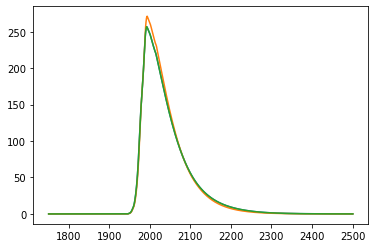

In [11]:
pl.plot(np.arange(1750.5, 2501), cfc11_concentrations)
pl.plot(np.arange(1750.5, 2501), cfc11_concentrations_rfmip)
pl.plot(np.arange(1750+1/24, 2501, 1/12), cfc11_concentrations_monthly)

### CO2

important to get correct

In [12]:
co2_emissions  # unit: GtCO2 / yr

array([ 0.30697023,  0.31244306,  0.31802027,  0.32369631,  0.32948047,
        0.33537096,  0.34201646,  0.34812553,  0.35434692,  0.36068269,
        0.36713125,  0.37466298,  0.38135469,  0.38816944,  0.39510948,
        0.40217713,  0.41065336,  0.4179833 ,  0.42544801,  0.43304998,
        0.44079172,  0.45002099,  0.45805008,  0.46622681,  0.47455389,
        0.48303408,  0.49308928,  0.50188422,  0.51084088,  0.51996225,
        0.52925505,  0.54051468,  0.55014858,  0.55996334,  0.56995482,
        0.58013771,  0.59279864,  0.60335523,  0.6141022 ,  0.6250505 ,
        0.63620008,  0.64980889,  0.66201897,  0.67381004,  0.68574822,
        0.69796617,  0.71149677,  0.7253139 ,  0.73922385,  0.75371674,
        0.76888294,  0.78227564,  0.80465962,  0.81382368,  0.83114241,
        0.84500388,  0.86151281,  0.87920763,  0.89216634,  0.90795154,
        0.92626321,  0.9448086 ,  0.96284398,  0.97998411,  0.99817425,
        1.01717938,  1.03979866,  1.06017879,  1.07905176,  1.09

In [14]:
co2_concentrations = np.ones(len(co2_emissions)) * np.nan

co2_boxes = 0  # confusion with alpha parameter
airborne_emissions = 0
pre_industrial_concentration = 278.3
co2_concentrations[0] = pre_industrial_concentration  # TODO: provide pre-defined PI controls
co2_cumulative_emissions = np.cumsum(co2_emissions)
iirf_0 = 29
iirf_cumulative = 0.031/3.664
iirf_temperature = 4.0
iirf_airborne = 0.003/3.664

iirf_horizon = 100
g1 = np.sum(partition_fractions['CO2'] * lifetime['CO2'] * (1 - (1 + iirf_horizon/lifetime['CO2']) * np.exp(-iirf_horizon/lifetime['CO2'])))
g0 = 1/(np.sinh(np.sum(partition_fractions['CO2']*lifetime['CO2']*(1 - np.exp(-iirf_horizon/lifetime['CO2'])) , axis=-1)/g1))

print(g1, g0)

for i in range(len(co2_emissions)):
    
    # airborne_emissions = np.sum(co2_boxes)
    
    alpha_lifetime = calculate_alpha(
        co2_cumulative_emissions[i],
        airborne_emissions,
        ssp245_temperature_rfmip[i],
        iirf_0,
        iirf_cumulative,
        iirf_temperature,
        iirf_airborne,
        g0,
        g1,
    )
    
    co2_concentrations[i], co2_boxes, airborne_emissions = step_concentration_co2(
        co2_emissions[i], 
        co2_boxes,
        airborne_emissions, 
        burden_per_emission['CO2'], # could be taken from constants
        alpha_lifetime=alpha_lifetime,
        pre_industrial_concentration=278.3,  # put in a defaults module
        timestep=1,
    )

11.412622431258765 0.020358685640761567


Here, we see an almost perfect agreement with the MAGICC-derived CO2 projections with appropriate carbon cycle parameter tuning

Text(0.5, 1.0, 'CO2 concentrations: SSP2-4.5')

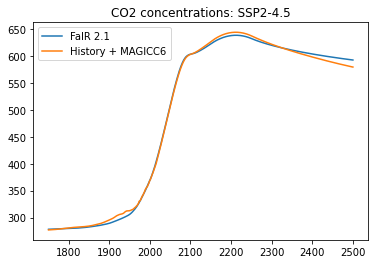

In [15]:
pl.plot(np.arange(1750.5, 2501), co2_concentrations, label='FaIR 2.1')
pl.plot(np.arange(1750.5, 2501), co2_concentrations_rfmip, label='History + MAGICC6')
#pl.plot(np.arange(1750+1/24, 2501, 1/12), cfc11_concentrations_monthly)
pl.legend()
pl.title('CO2 concentrations: SSP2-4.5')

In [16]:
co2_concentrations[270], co2_concentrations_rfmip[270]

(416.7828807976373, 414.3899637858073)

### Methane: an in-between case

methane has a lifetime feedback, and it also affects ozone and stratospheric water vapor forcing.

The step concentration for a one-box gas will work here, but we need an alpha adjustment.

In [17]:
ch4_concentrations = np.ones(len(ch4_emissions)) * np.nan

ch4_boxes = 0
airborne_emissions = 0
pre_industrial_concentration = 729.2
ch4_concentrations[0] = pre_industrial_concentration # TODO: provide pre-defined PI controls
ch4_cumulative_emissions = np.cumsum(ch4_emissions) # cumulative emissions are not contributing to methane lifetime, but we'll track them in case future research makes them relevant
iirf_0 = lifetime['CH4']
iirf_cumulative = 0.0
iirf_temperature = -0.3
iirf_airborne = 0.00032
iirf_horizon = 100

g1 = lifetime['CH4'] * (1 - (1 + iirf_horizon/lifetime['CH4']) * np.exp(-iirf_horizon/lifetime['CH4']))
g0 = 1/(np.sinh((lifetime['CH4']*(1 - np.exp(-iirf_horizon/lifetime['CH4'])))/g1))

ch4_lifetime = np.ones(len(ch4_emissions)) * np.nan

for i in range(len(ch4_emissions)):
    alpha_lifetime = calculate_alpha(
        ch4_cumulative_emissions[i],
        airborne_emissions,
        ssp245_temperature_rfmip[i],
        iirf_0,
        iirf_cumulative,
        iirf_temperature,
        iirf_airborne,
        g0,
        g1,
    )
    
    ch4_lifetime[i] = alpha_lifetime * lifetime['CH4']
    
    ch4_concentrations[i], airborne_emissions = step_concentration_1box(
        ch4_emissions[i], 
        airborne_emissions, 
        lifetime['CH4'],
        burden_per_emission['CH4'], # could be taken from constants
        alpha_lifetime=alpha_lifetime,
        pre_industrial_concentration=pre_industrial_concentration,  # put in a defaults module
        timestep=1,
    )

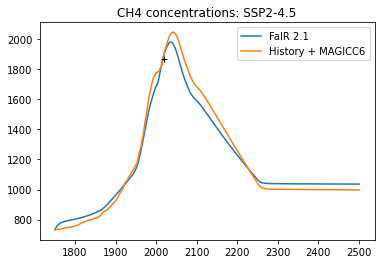

In [18]:
pl.plot(np.arange(1750.5, 2501), ch4_concentrations, label='FaIR 2.1')
pl.plot(np.arange(1750.5, 2501), ch4_concentrations_rfmip, label='History + MAGICC6')
#pl.plot(np.arange(1750+1/24, 2501, 1/12), cfc11_concentrations_monthly)
pl.legend()
pl.title('CH4 concentrations: SSP2-4.5')
pl.plot(2020, 1870, 'k+')

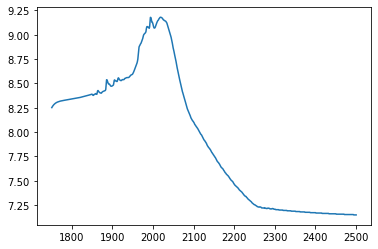

In [19]:
pl.plot(np.arange(1750.5, 2501), ch4_lifetime)

In [20]:
ch4_concentrations[270]

1911.5546468785337

In [21]:
ch4_lifetime[258:268].mean()  # good job, Nick. IPCC assess 9.1

9.148354986900035